In [99]:
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11155358849455588106
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14891705185104472546
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18058818473635560541
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10852871744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18120267569396370440
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [100]:
#!pip install tensorflow==2.3.0

In [101]:
root = '/content/drive/My Drive/SRI/'
trainData = '/content/drive/My Drive/SRI/articles-training-byarticle-20181122.xml'
groundTruth = '/content/drive/My Drive/SRI/ground-truth-training-byarticle-20181122.xml'

In [102]:
#### parse data
import xml.etree.ElementTree as ET

tree = ET.parse(trainData)
root = tree.getroot()

In [103]:
data = pd.DataFrame(columns = ['id', 'text', 'word_count', 'label'])

for child in root:
  text = ET.tostring(child, method='text')
  
  data = data.append({'id': int(child.get('id')), 'text': text } , ignore_index=True)

In [104]:
data.head(5)

,id,text,word_count,label
0,0,b'\nFrom flickr.com: Money {MID-161793} Money ...,NaN,NaN
1,1,b'Donald Trump ran on many braggadocios and la...,NaN,NaN
2,2,b'\nPhoto By Justin Sullivan/Getty Images In r...,NaN,NaN
3,3,b'After Colin Kaepernick rightly chose to knee...,NaN,NaN
4,4,"b'Almost a half-century ago, in 1968, the Unit...",NaN,NaN


In [105]:
!pip install gensim

In [106]:
#### clean data
from gensim.parsing.preprocessing import remove_stopwords, strip_tags, strip_multiple_whitespaces, strip_punctuation2, strip_numeric, stem_text

def clean_data(text):

  tmp = strip_tags(text)
  tmp = strip_multiple_whitespaces(tmp)
  tmp = strip_punctuation2(tmp)
  tmp = strip_numeric(tmp)
  tmp = remove_stopwords(tmp)
  tmp = ' '.join([x.lower() for x in tmp.split(' ')])
  #tmp = stem_text(tmp)

  return tmp


In [107]:
cleanData = data
cleanData['text'] = cleanData['text'].apply(clean_data)

In [108]:
### inspect the cleaned data
cleanData.iloc[0]['text']

'from flickr com money mid money image k permission details dmca no pill can stop tinnitus but this weird trick can the walls closing congress terrifying walls water hurricanes harvey irma damage totaled rise half trillion dollars the walls war the multi trillion dollar ongoing cost afghanistan iraq interventions the crumbling walls u s infrastructure need trillion repaired replaced a wall million undocumented immigrants deportation easily cost billion the planned wall mexican border estimates place billion then wall all trillion national debt the walls debt closing at moments crisis nation addition invoking assistance higher powers constitution guidance article i section u s constitution contains long forgotten provision coinage clause empowered congress coin create money the ability create money meet needs nation sovereign power enables nation control destiny the article indicates founders anticipated having borrow money faith credit united states enter funding act assumed paid debt 

In [109]:
#### get text length distribution
#cleanData.insert(2, 'word_count', cleanData.shape[0]*[0])

In [110]:
print(cleanData)

      id                                               text word_count label
0      0  from flickr com money mid money image k permis...        NaN   NaN
1      1  donald trump ran braggadocios largely unrealis...        NaN   NaN
2      2  photo by justin sullivan getty images in respo...        NaN   NaN
3      3  after colin kaepernick rightly chose kneel nat...        NaN   NaN
4      4  almost half century ago united states falling ...        NaN   NaN
..   ...                                                ...        ...   ...
640  640  donald trump photo whitehouse gov madison u s ...        NaN   NaN
641  641  president donald trump tuesday began dismantli...        NaN   NaN
642  642  the us supreme court ruled donald trump s ban ...        NaN   NaN
643  643  ex fbi director james comey went rogue accordi...        NaN   NaN
644  644  ashley judd absolute worst i want like i somet...        NaN   NaN

[645 rows x 4 columns]


In [111]:
cleanData['word_count'] = cleanData.apply(lambda x: len(x.text.split(' ')), axis=1)

In [112]:
print(cleanData)

      id                                               text  word_count label
0      0  from flickr com money mid money image k permis...         818   NaN
1      1  donald trump ran braggadocios largely unrealis...         121   NaN
2      2  photo by justin sullivan getty images in respo...          94   NaN
3      3  after colin kaepernick rightly chose kneel nat...         176   NaN
4      4  almost half century ago united states falling ...         481   NaN
..   ...                                                ...         ...   ...
640  640  donald trump photo whitehouse gov madison u s ...         148   NaN
641  641  president donald trump tuesday began dismantli...         479   NaN
642  642  the us supreme court ruled donald trump s ban ...         131   NaN
643  643  ex fbi director james comey went rogue accordi...          64   NaN
644  644  ashley judd absolute worst i want like i somet...         219   NaN

[645 rows x 4 columns]


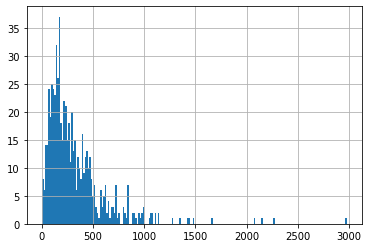

In [113]:
hist = cleanData['word_count'].hist(bins=200)

In [114]:
####### add labels
tree = ET.parse(groundTruth)
root = tree.getroot()


for child in root:
  id = int(child.get('id'))

  label = 1 if child.get('hyperpartisan') == "true" else 0

  cleanData.loc[id, 'label'] = label

print(cleanData)

      id                                               text  word_count label
0      0  from flickr com money mid money image k permis...         818     1
1      1  donald trump ran braggadocios largely unrealis...         121     1
2      2  photo by justin sullivan getty images in respo...          94     1
3      3  after colin kaepernick rightly chose kneel nat...         176     1
4      4  almost half century ago united states falling ...         481     0
..   ...                                                ...         ...   ...
640  640  donald trump photo whitehouse gov madison u s ...         148     1
641  641  president donald trump tuesday began dismantli...         479     0
642  642  the us supreme court ruled donald trump s ban ...         131     0
643  643  ex fbi director james comey went rogue accordi...          64     0
644  644  ashley judd absolute worst i want like i somet...         219     1

[645 rows x 4 columns]


In [115]:
#### convert longer sequences into 512 chunks
#### id  text  word_count label
chunkSize = 512
finalData = pd.DataFrame(columns=cleanData.columns)

counter = 0
for index, row in cleanData.iterrows():

  if row['word_count'] < 400:
    finalData.loc[counter] = row.values
    counter += 1
  else:

    for idx in range(0, row['word_count'], chunkSize):
      nextIdx = min(idx + chunkSize, row['word_count'])
      #print(idx, nextIdx , row['word_count'])
      txt = row['text'].split(' ')[idx:nextIdx]
      newData = {'id' : counter, 
                 'text': ' '.join(txt),
                 'word_count': len(txt), 
                 'label': np.float(row['label'])}

      finalData.loc[counter] = newData
      counter += 1


print(finalData)

      id                                               text word_count  label
0      0  from flickr com money mid money image k permis...        512    1.0
1      1  irma damage totaled rise half trillion dollars...        306    1.0
2      1  donald trump ran braggadocios largely unrealis...        121    1.0
3      2  photo by justin sullivan getty images in respo...         94    1.0
4      3  after colin kaepernick rightly chose kneel nat...        176    1.0
..   ...                                                ...        ...    ...
772  640  donald trump photo whitehouse gov madison u s ...        148    1.0
773  773  president donald trump tuesday began dismantli...        479    0.0
774  642  the us supreme court ruled donald trump s ban ...        131    0.0
775  643  ex fbi director james comey went rogue accordi...         64    0.0
776  644  ashley judd absolute worst i want like i somet...        219    1.0

[777 rows x 4 columns]


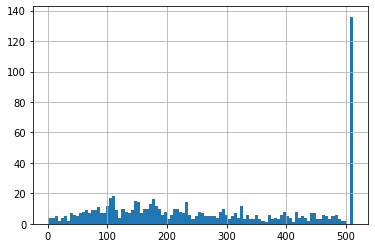

In [116]:
hist = finalData['word_count'].hist(bins=100)

In [159]:
#### helper plot function
def plot_acc_loss(history, model):
  plt.plot(history.history['acc'], label='acc')
  plt.plot(history.history['val_acc'], label='val_acc')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_los')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

In [118]:
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [119]:
!pip install flair

In [ ]:
##################################################### model 3 flair embeddings
from flair.embeddings import FlairEmbeddings
from flair.data import Sentence

flair_embedding_forward = FlairEmbeddings('news-forward')
###rewrite the variables - keep labels
embeddings = []
labels =  []

############################ get encoded vectors and labels
for index, row in finalData.iterrows():

  sent_emb = []
  text = row['text']
  lstText = text.split(' ')

  if len(lstText) < 512:
    text = ' '.join(lstText + ['pad']*(512-len(lstText)))
  
  sent = Sentence(text)
  flair_embedding_forward.embed(sent)

  for token in sent:
    sent_emb.append(token.embedding.cpu().numpy())

  print(index)
  embeddings.append(sent_emb)
  labels.append(row['label'])


embeddings = np.array(embeddings)
labels = np.expand_dims(np.array(labels), axis=1)

print(embeddings.shape)
print(labels.shape)
########################## split the data 

x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
######################### build datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [145]:
embedding_dim = 2048

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=9, activation='relu', input_shape=(512,embedding_dim)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(128, kernel_size=9, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(128, kernel_size=9, activation='relu'),
    tf.keras.layers.Conv1D(128, kernel_size=9, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 504, 128)          2359424   
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 252, 128)          0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 244, 128)          147584    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 122, 128)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 114, 128)          147584    
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 106, 128)          147584    
_________________________________________________________________
dense_34 (Dense)             (None, 106, 256)        

In [146]:
history = model.fit(train_dataset, batch_size=32, epochs=50, validation_data=test_dataset)

Epoch 1/50
20/20 [==============================] - 7s 368ms/step - loss: 0.6794 - acc: 0.5982 - val_loss: 0.6275 - val_acc: 0.6859
Epoch 2/50
20/20 [==============================] - 6s 307ms/step - loss: 0.6427 - acc: 0.6671 - val_loss: 0.5926 - val_acc: 0.7102
Epoch 3/50
20/20 [==============================] - 6s 307ms/step - loss: 0.6191 - acc: 0.6825 - val_loss: 0.5773 - val_acc: 0.7121
Epoch 4/50
20/20 [==============================] - 6s 307ms/step - loss: 0.6047 - acc: 0.6916 - val_loss: 0.5668 - val_acc: 0.7169
Epoch 5/50
20/20 [==============================] - 6s 307ms/step - loss: 0.5905 - acc: 0.7005 - val_loss: 0.5558 - val_acc: 0.7291
Epoch 6/50
20/20 [==============================] - 6s 309ms/step - loss: 0.5792 - acc: 0.7109 - val_loss: 0.5500 - val_acc: 0.7310
Epoch 7/50
20/20 [==============================] - 6s 312ms/step - loss: 0.5678 - acc: 0.7182 - val_loss: 0.5469 - val_acc: 0.7333
Epoch 8/50
20/20 [==============================] - 6s 302ms/step - loss: 0.

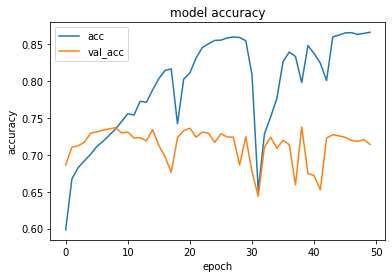

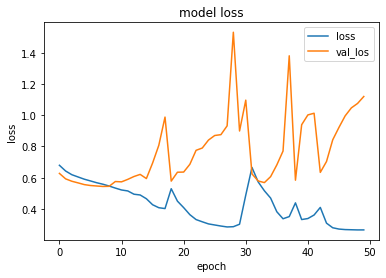

In [160]:
###### model 3 results
print(history)
plot_acc_loss(history, model)